In [26]:
import pandas as pd
import statistics as stats

# sklearn utility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import export_text

# sklearn grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score

import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("base_chess_data.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...


In [28]:
# add number of moves to each game

game_num_moves = []

for index, row in df.iterrows():
    num_moves_by_both = len(row['Moves'].split(" "))
    num_white_moves = (num_moves_by_both // 2) + (num_moves_by_both % 2 == 1)
    game_num_moves.append(num_white_moves)


df['NumWhiteMoves'] = game_num_moves
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25


In [29]:
# There are many games where the only move made was the first one, and then the match was cancelled.
# We still want to remove those.

list_to_remove = []
for index, row in df.iterrows():
    if(len(row['Moves'].split(" ")) <= 2):
        list_to_remove.append(index)

df = df.drop(list_to_remove)



In [30]:
# add column for all deltas

# For moves with NA, we assume they have 0 change in the current board strength.

deltas = []

for index, row in df.iterrows():
    
    boardStrengths = row["StockfishScores"].split(" ")
    
    delta_string = ""
    current_board_strength = 0

    for score in boardStrengths:
        if(score == "NA"):
            delta_string += "0 "
            continue
        
        try:
            numeric_score = int(score)
        except:
            print(row["Moves"])
        delta = numeric_score - current_board_strength
        delta_string += str(delta) + " "

        current_board_strength = numeric_score

    delta_string = delta_string[:-1] # remove trailing whitespace
    
    deltas.append(delta_string)


df['StockfishDeltas'] = deltas

df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7,26 18 -18 -8 -4 20 2 -5 6 -2 7 10 3
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...


In [31]:
df.head()

,WhiteElo,BlackElo,WhiteWins,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas
0,2354,2411,1,Nf3 Nf6 c4 c5 b3 g6 Bb2 Bg7 e3 O-O Be2 b6 O-O ...,18 17 12 8 -5 12 3 -2 22 21 20 13 8 21 11 3 -6...,19,18 -1 -5 -4 -13 17 -9 -5 24 -1 -1 -7 -5 13 -10...
1,2523,2460,1,e4 e5 Nf3 Nf6 d4 Nxe4 Nxe5 d6 Nf3 d5 Bd3 Nd6 O-O,26 44 26 18 14 34 36 31 37 35 42 52 55,7,26 18 -18 -8 -4 20 2 -5 6 -2 7 10 3
2,1915,1999,0,e4 d5 exd5 Nf6 d4 Nxd5 Nf3 g6 Be2 Bg7 c4 Nb6 N...,26 51 68 57 65 77 48 93 61 63 63 58 53 46 69 2...,53,26 25 17 -11 8 12 -29 45 -32 2 0 -5 -5 -7 23 -...
3,2446,2191,2,c4 Nf6 Nc3 d6 d4 e5 Nf3 Nbd7 Bg5 Be7 e3 c6 Qc2...,2 21 5 53 35 45 37 54 10 22 8 48 30 17 13 35 -...,39,2 19 -16 48 -18 10 -8 17 -44 12 -14 40 -18 -13...
4,2168,2075,2,e4 c5 Nf3 d6 b4 Nf6 bxc5 Nxe4 cxd6 Qb6 d4 Bg4 ...,26 64 35 53 18 20 18 20 10 49 60 95 91 82 83 9...,25,26 38 -29 18 -35 2 -2 2 -10 39 11 35 -4 -9 1 1...


We want to stratify our train/test/validation sets based on the length of the games as well as whether white wins. So, we will create bins for the 'short,' 'medium', and 'long' games. The code will create 3 bins, and can be changed to create more bins.

In [32]:
df['numMovesBin'] = pd.qcut(df['NumWhiteMoves'], q=3, labels=[1,2,3])
df.head()
df['numMovesBin'].value_counts()

1    8487
2    8382
3    8103
Name: numMovesBin, dtype: int64

In [33]:
# stratify the data only based on whether white wins
x_train, x_test, y_train, y_test = train_test_split(df, df['WhiteWins'], test_size=0.2, random_state=45, stratify=df[['WhiteWins', 'numMovesBin']])
x_train = x_train.drop('WhiteWins', axis=1)
x_test = x_test.drop('WhiteWins', axis=1)
x_train.head()

,WhiteElo,BlackElo,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas,numMovesBin
18383,2401,2001,Nf3 Nf6 c4 c5 Nc3 d6 g3 g6 Bg2 Bg7 d4 cxd4 Nxd...,18 17 12 8 22 46 0 7 21 24 32 34 39 41 39 33 3...,24,18 -1 -5 -4 14 24 -46 7 14 3 8 2 5 2 -2 -6 6 -...,1
11894,1939,2473,d4 g6 Nf3 Bg7 c4 Nf6 Nc3 d5 cxd5 Nxd5 e4 Nxc3 ...,19 77 51 74 53 46 33 65 50 51 52 54 36 47 41 2...,60,19 58 -26 23 -21 -7 -13 32 -15 1 1 2 -18 11 -6...,3
3851,2415,2303,e4 c5 Nf3 d6 c3 Nf6 h3 Nc6 Bd3 d5 e5 Nd7 Bb5 e...,26 64 35 53 18 13 2 -23 -17 -15 -11 -30 -23 -2...,70,26 38 -29 18 -35 -5 -11 -25 6 2 4 -19 7 3 1 -1...,3
24090,2329,2249,e4 e5 d4 exd4 c3 d5 exd5 Qxd5 cxd4 Qe4+ Be3 Nf...,26 45 8 21 -12 -21 -7 9 2 50 41 66 51 37 72 65...,62,26 19 -37 13 -33 -9 14 16 -7 48 -9 25 -15 -14 ...,3
15670,1885,1930,e4 c5 Nf3 e6 d4 cxd4 Nxd4 Nf6 Nc3 d6 Bg5 Be7 Q...,26 64 35 42 38 38 22 33 17 31 20 22 13 4 2 11 ...,18,26 38 -29 7 -4 0 -16 11 -16 14 -11 2 -9 -9 -2 ...,1


In [34]:
type(y_train)
y_train

18383    2
11894    0
3851     2
24090    1
15670    0
        ..
20592    1
20293    2
19410    2
20007    2
17932    2
Name: WhiteWins, Length: 19977, dtype: int64

In [35]:
# create a validation set

x_primtrain, x_valid, y_primtrain, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=45, stratify=y_train)
x_primtrain.shape[0], x_valid.shape[0], x_train.shape[0]

(15981, 3996, 19977)

## New Dataframe: Row For Each Move

Now that we have training/test/validation sets per game, we will create new dataframes based on the row for each move. For example, a game that lasts 30 games will have 30 rows, each of which will have information of its game up to the Nth move. We will add a column for them to also include their current move.

NOTE THAT some of the moves from stockfish, from this example, have "NA" as their stockfish score, because the computation would have taken too long. In these instances, we decide to use the previous move's data.

In [36]:
# TODO
# TODO Figure out the specifics of stockfish: whether we decide the early-drawed games are the same as actual draws or bad data,
# TODO how stockfish makes the scores and what it values non-pawns as, 
# TODO

In [37]:
from buildChessDFPerMove import buildChessDataframePerMove

x_trainPerMove, y_trainPerMove = buildChessDataframePerMove(x_primtrain, y_primtrain)
x_testPerMove, y_testPerMove = buildChessDataframePerMove(x_test, y_test)
x_validPerMove, y_validPerMove = buildChessDataframePerMove(x_valid, y_valid)

After creating a row for each of our 25000 games, our training set (containing 18000 of these games) has 1316297 rows.

In [38]:
x_trainPerMove.head()
y_trainPerMove.head()

Game ID  Move Number
16404    1              2
         2              2
         3              2
         4              2
         5              2
dtype: int64

In [39]:
x_trainPerMove
#y_trainPerMove

,,WhiteElo,BlackElo,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta
,GameId,,,,,,,
0,16404,2061,1865,1,1,26,26.000000,0.000000
1,16404,2061,1865,2,0,44,26.000000,18.000000
2,16404,2061,1865,3,1,26,4.000000,18.000000
3,16404,2061,1865,4,0,14,4.000000,3.000000
4,16404,2061,1865,5,1,19,4.333333,3.000000
...,...,...,...,...,...,...,...,...
1316292,14898,2815,2771,105,1,320,-4.698113,10.942308
1316293,14898,2815,2771,106,0,301,-4.698113,10.377358
1316294,14898,2815,2771,107,1,331,-4.055556,10.377358


In [40]:
x_primtrain

,WhiteElo,BlackElo,Moves,StockfishScores,NumWhiteMoves,StockfishDeltas,numMovesBin
16404,2061,1865,e4 e5 Nf3 Nc6 Bc4 Bc5 c3 Nf6 d3 a6 Bb3 Ba7 O-O...,26 44 26 14 19 53 22 9 6 29 0 13 12 22 14 18 1...,48,26 18 -18 -12 5 34 -31 -13 -3 23 -29 13 -1 10 ...,3
12749,2408,2340,d4 Nf6 c4 e6 Nf3 Bb4+ Bd2 Qe7 Bc3 b6 a3 Bxc3+ ...,19 17 22 22 28 33 30 63 35 32 26 32 29 24 5 24...,38,19 -2 5 0 6 5 -3 33 -28 -3 -6 6 -3 -5 -19 19 -...,2
16361,2323,2415,e4 d5 e5 Bf5 d4 e6 c3 c5 f4 Nc6 Nf3 h5 Bd3 Nh6...,26 51 7 22 24 24 -3 5 -57 -64 -73 -18 -54 -50 ...,42,26 25 -44 15 2 0 -27 8 -62 -7 -9 55 -36 4 9 3 ...,2
21658,2264,2078,Nf3 Nf6 d4 g6 Bg5 Bg7 Nbd2 d5 e3 O-O c4 c5 dxc...,15 17 8 48 36 21 34 15 31 24 -1 17 -13 41 67 5...,24,15 2 -9 40 -12 -15 13 -19 16 -7 -25 18 -30 54 ...,1
9083,2039,2273,e4 e6 d4 d5 Nc3 Nf6 e5 Nfd7 Nf3 c5 dxc5 Nc6 Bf...,26 42 43 29 31 22 12 0 -3 0 -33 -2 -32 -34 -29...,49,26 16 1 -14 2 -9 -10 -12 -3 3 -33 31 -30 -2 5 ...,3
...,...,...,...,...,...,...,...
5706,2210,2563,c4 c5 Nf3 Nc6 g3 e5 Nc3 g6 Bg2 Bg7 O-O d6 a3 a...,2 26 14 13 -6 -10 0 13 26 13 18 14 22 18 18 25...,65,2 24 -12 -1 -19 -4 10 13 13 -13 5 -4 8 -4 0 7 ...,3
24395,2558,2263,d4 Nf6 Nf3 g6 g3 Bg7 Bg2 O-O O-O d6 a4 a5 Na3 ...,19 17 8 48 13 6 15 6 22 41 7 22 11 7 17 22 35 ...,46,19 -2 -9 40 -35 -7 9 -9 16 19 -34 15 -11 -4 10...,2
24645,2339,2579,d4 g6 e4 Bg7 Nf3 d6 c3 Nf6 Bd3 O-O O-O Nc6 b4 ...,19 71 91 62 72 70 37 55 42 36 54 66 31 32 9 10...,36,19 52 20 -29 10 -2 -33 18 -13 -6 18 12 -35 1 -...,2
10162,2164,2537,e4 c5 Nf3 Nc6 d4 cxd4 Nxd4 e5 Nb5 d6 N1c3 a6 N...,26 64 35 63 22 33 8 -4 7 25 0 -22 -5 14 -6 46 ...,41,26 38 -29 28 -41 11 -25 -12 11 18 -25 -22 17 1...,2


In [41]:
x_primtrain.describe()

,WhiteElo,BlackElo,NumWhiteMoves
count,15981.000000,15981.000000,15981.000000
mean,2248.934798,2243.802891,41.452162
std,268.245173,271.087936,16.856727
min,1137.000000,1158.000000,2.000000
25%,2077.000000,2069.000000,30.000000
50%,2274.000000,2269.000000,40.000000
75%,2449.000000,2448.000000,51.000000
max,2864.000000,2881.000000,165.000000


In [42]:
df.corr()

C:\Users\stard\AppData\Local\Temp\ipykernel_36564\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,WhiteElo,BlackElo,WhiteWins,NumWhiteMoves
WhiteElo,1.000000,0.626771,0.241418,0.058197
BlackElo,0.626771,1.000000,-0.229065,0.077789
WhiteWins,0.241418,-0.229065,1.000000,-0.025872
NumWhiteMoves,0.058197,0.077789,-0.025872,1.000000


# Building a Multinomial Logistic Model

# Building an XGBoost Model

In [43]:
x_trainPerMove.head()

,,WhiteElo,BlackElo,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta
,GameId,,,,,,,
0,16404,2061,1865,1,1,26,26.000000,0.0
1,16404,2061,1865,2,0,44,26.000000,18.0
2,16404,2061,1865,3,1,26,4.000000,18.0
3,16404,2061,1865,4,0,14,4.000000,3.0
4,16404,2061,1865,5,1,19,4.333333,3.0


In [44]:
# TODO: update the train, test, split to not 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_trainPerMove)
x_valid_scaled = scaler.transform(x_validPerMove)
x_test_scaled = scaler.transform(x_testPerMove)

Because of an XGBoost error (`ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]`), we have to change what WhiteWins represents. A 2 is white winning, a 1 is a tie, and a 0 is black winning.

In [48]:
gbm = xgb.XGBClassifier(random_state=42)
model = gbm.fit(x_train_scaled, y_trainPerMove,
                eval_set = [[x_train_scaled, y_trainPerMove],
                          [x_valid_scaled, y_validPerMove]]#,
               #eval_set = 'logloss',
                #early_stopping_rounds=10
                )

# was tests
xgb_valid_preds = model.predict(x_valid_scaled)
xgb_valid_proba = model.predict_proba(x_valid_scaled)

[0]	validation_0-mlogloss:0.97693	validation_1-mlogloss:0.97984
[1]	validation_0-mlogloss:0.90268	validation_1-mlogloss:0.90847
[2]	validation_0-mlogloss:0.85364	validation_1-mlogloss:0.86235
[3]	validation_0-mlogloss:0.81941	validation_1-mlogloss:0.83108
[4]	validation_0-mlogloss:0.79556	validation_1-mlogloss:0.80968
[5]	validation_0-mlogloss:0.77848	validation_1-mlogloss:0.79498
[6]	validation_0-mlogloss:0.76607	validation_1-mlogloss:0.78487
[7]	validation_0-mlogloss:0.75659	validation_1-mlogloss:0.77764
[8]	validation_0-mlogloss:0.74941	validation_1-mlogloss:0.77261
[9]	validation_0-mlogloss:0.74366	validation_1-mlogloss:0.76863
[10]	validation_0-mlogloss:0.73911	validation_1-mlogloss:0.76571
[11]	validation_0-mlogloss:0.73552	validation_1-mlogloss:0.76396
[12]	validation_0-mlogloss:0.73247	validation_1-mlogloss:0.76261
[13]	validation_0-mlogloss:0.72994	validation_1-mlogloss:0.76146
[14]	validation_0-mlogloss:0.72688	validation_1-mlogloss:0.76118
[15]	validation_0-mlogloss:0.72393	

In [47]:
xgb_valid_proba

array([[0.40668845, 0.33711228, 0.25619927],
       [0.41626826, 0.35810605, 0.22562563],
       [0.40514916, 0.33873668, 0.25611416],
       ...,
       [0.48210835, 0.3522906 , 0.16560104],
       [0.6488543 , 0.24262351, 0.10852218],
       [0.5578418 , 0.2830934 , 0.15906489]], dtype=float32)

In [52]:
x_validPerMove.head()

,,WhiteElo,BlackElo,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta
,GameId,,,,,,,
0,14922,2242,2406,1,1,2,2.0,0.0
1,14922,2242,2406,2,0,15,2.0,13.0
2,14922,2242,2406,3,1,5,-4.0,13.0
3,14922,2242,2406,4,0,25,-4.0,16.5
4,14922,2242,2406,5,1,27,-2.0,16.5


In [55]:
# More multiindexing can be found at https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
# for example, getting all games with the same id of 14922.

x_validPerMove.loc[pd.IndexSlice[:, 14922], :]

,,WhiteElo,BlackElo,MoveNumber,WhiteTurn,CurrentStockfishScore,WhiteAverageDelta,BlackAverageDelta
,GameId,,,,,,,
0,14922,2242,2406,1,1,2,2.000000,0.000000
1,14922,2242,2406,2,0,15,2.000000,13.000000
2,14922,2242,2406,3,1,5,-4.000000,13.000000
3,14922,2242,2406,4,0,25,-4.000000,16.500000
4,14922,2242,2406,5,1,27,-2.000000,16.500000
...,...,...,...,...,...,...,...,...
86,14922,2242,2406,87,1,-336,-10.159091,2.581395
87,14922,2242,2406,88,0,-335,-10.159091,2.545455
88,14922,2242,2406,89,1,-358,-10.444444,2.545455


In [56]:
y_validPerMove.head()

Game ID  Move Number
14922    1              0
         2              0
         3              0
         4              0
         5              0
dtype: int64

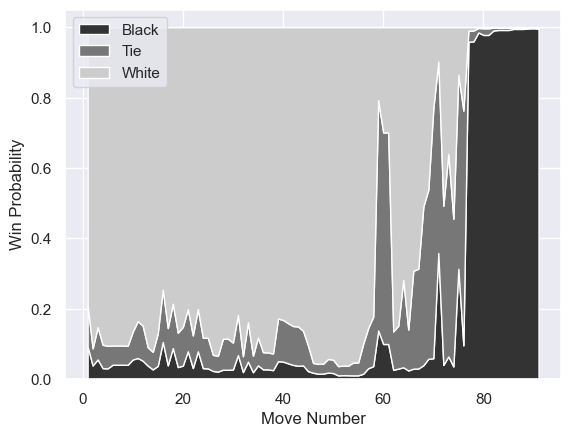

In [75]:
def buildStackedLinearWPPlot(dataframe, game_id, model, scaler):
    '''
    Creates a stacked linear plot of predicted win probabilities using a win probability model.
    
    Parameters:
    - dataframe: the pandas dataframe (non-scaled) with all the data. 
    - game_id: the id of the game to be used (integer).
    - model: Some subtype of Classifier. Must have a predict_proba() function to use on the dataframe.

    - scaler: how the data is scaled before using the model.
    '''

    df_to_predict = dataframe.loc[pd.IndexSlice[:, game_id], :]
    scaled_df_to_predict = scaler.fit_transform(df_to_predict)
    probabilities = model.predict_proba(scaled_df_to_predict)

    move_numbers = df_to_predict.loc[:,'MoveNumber'].values
    black_probas = probabilities[:,0]
    tie_probas = probabilities[:,1]
    white_probas = probabilities[:,2]


    sns.set_theme(palette=None)
    color_map = ['#333', '#777', '#ccc']
    plt.stackplot(move_numbers, 
                  black_probas, 
                  tie_probas, 
                  white_probas, 
                  colors=color_map, 
                  labels=['Black', 'Tie', 'White'],)

    plt.xlabel('Move Number')
    plt.ylabel('Win Probability')
    plt.legend(loc='upper left')
    #plt.stackplot(df.x, df.y1, df.y2, df.y3)

    return

buildStackedLinearWPPlot(x_validPerMove, 14922, model, scaler)

In [ ]:
buildStackedLinearWPPlot(x_validPerMove, 14922, model, scaler)